#### Set dataset path (download if running on remote session)

In [2]:
import os

DATA_PATH = None
RUNNING_REMOTE = False
if RUNNING_REMOTE:
    ! pip install kagglehub
    import kagglehub
    
    path = kagglehub.dataset_download(handle="geoparslp/patreco3-multitask-affective-music")
    DATA_PATH = os.path.join(path, "data/")
else:
    DATA_PATH = os.path.join(os.getcwd(), "data/")
print("Path to dataset files:", DATA_PATH)

Path to dataset files: /home/vag/Documents/DSML/PatternRecognition/BeatPatrol/data/


#### Import utilities and set notebook variables

In [3]:
!pip install timm==0.4.5 
from utils import SpectrogramDataset, torch_train_val_split, ASTBackbone, get_regression_report, \
    CLASS_MAPPING, Classifier, Regressor, train, get_device, free_gpu_memory, test_model, plot_train_val_losses, \
    get_classification_report
import torch

model_weights_path = os.path.join(os.getcwd(), "model_weights/")
assets_path = os.path.join(os.getcwd(), "assets/")

mel_specs_path = DATA_PATH + "fma_genre_spectrograms/"
beat_mel_specs_path = DATA_PATH + "fma_genre_spectrograms_beat/"
multitask_path = DATA_PATH + "multitask_dataset/"
os.makedirs(model_weights_path, exist_ok=True)
os.makedirs(assets_path, exist_ok=True)

EPOCHS = 100
LR = 1e-4
BATCH_SIZE = 8
VAL_SIZE = .2
RANDOM_SEED = 42
NUM_CATEGORIES = 10
AST_MODEL_SIZES = ['tiny224', 'small224', 'base224', 'base384']
LOAD_PRETRAINED = True

if torch.cuda.is_available():
    print(f"Detected GPU: {torch.cuda.get_device_name(0)}")
    print(f"Free GPU Memory: {free_gpu_memory():.2f}%")
else:
    print("CUDA is not available. No compatible GPU detected.")
DEVICE = get_device()

Detected GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Free GPU Memory: 100.00%


#### Train a classifier on the *fma_genre_spectrograms* Dataset and save the weights on epoch with best performance 

In [4]:
import torch
import torch.optim as optim

mel_specs_data = SpectrogramDataset(mel_specs_path, class_mapping=CLASS_MAPPING, train=True)
mel_specs_train_dl, mel_specs_val_dl = torch_train_val_split(
    dataset=mel_specs_data,
    batch_eval=BATCH_SIZE,
    batch_train=BATCH_SIZE,
    val_size=VAL_SIZE,
    shuffle=True,
)

x_b1, _, _ = next(iter(mel_specs_train_dl))
input_shape = x_b1[0].shape

# init AST Backbone and classifier
model_size = AST_MODEL_SIZES[0]
backbone = ASTBackbone(
    fstride=10,
    tstride=10,
    input_fdim=input_shape[1],
    input_tdim=input_shape[0],
    imagenet_pretrain=True,
    model_size=model_size,
    feature_size=NUM_CATEGORIES,
)
model = Classifier(NUM_CATEGORIES, backbone).to(DEVICE)
genre_optimizer = optim.Adam(model.parameters(), lr=LR)

pretrained_weights = model_weights_path + model_size + "_ast_spectrogram_pretraining.pth"

if LOAD_PRETRAINED:
    model.load_state_dict(torch.load(pretrained_weights, map_location=DEVICE, weights_only=True))
else:
    # Train the model on Spectrograms
    train_losses, val_losses = train(
        model,
        mel_specs_train_dl,
        mel_specs_val_dl,
        genre_optimizer,
        EPOCHS,
        device=DEVICE,
        patience=3,
        save_path=pretrained_weights,
    )
    plot_train_val_losses(train_losses, val_losses)

In [3]:
print(f"Free GPU Memory: {free_gpu_memory():.2f}%")

Free GPU Memory: 99.44%


#### Use the pretrained weights from the model trained on *fma_genre_spectrograms* and fine-tune a Regressor on the *energy* Dataset 

Training started for model checkpoint...
Epoch 1/100
	Average Training Loss: 0.07716369210223181 (45.90s)
	Average Validation Loss: 0.06964775840086597(4.45s)
Epoch 2/100
	Average Training Loss: 0.07159647147739882 (45.23s)
	Average Validation Loss: 0.060608195806188245(4.44s)
Epoch 3/100
	Average Training Loss: 0.06569964021642123 (45.19s)
	Average Validation Loss: 0.05628726791058268(4.44s)
Epoch 4/100
	Average Training Loss: 0.06138750907462255 (45.21s)
	Average Validation Loss: 0.05212654499337077(4.44s)
Epoch 5/100
	Average Training Loss: 0.05284935703286819 (45.24s)
	Average Validation Loss: 0.07067300472408533(4.44s)
Epoch 6/100
	Average Training Loss: 0.05251844329512225 (45.23s)
	Average Validation Loss: 0.05043743770303471(4.44s)
Epoch 7/100
	Average Training Loss: 0.04508255587775359 (45.23s)
	Average Validation Loss: 0.04485976230353117(4.44s)
Epoch 8/100
	Average Training Loss: 0.04365238344577034 (45.26s)
	Average Validation Loss: 0.041800784678863626(4.45s)
Epoch 9/100
	

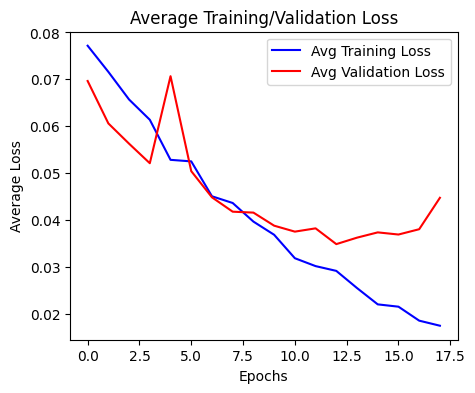

In [4]:
energy_data = SpectrogramDataset(
    multitask_path,
    class_mapping=CLASS_MAPPING,
    train=True,
    regression=2)

energy_train_dl, energy_val_dl = torch_train_val_split(
    dataset=energy_data,
    batch_eval=BATCH_SIZE,
    batch_train=BATCH_SIZE,
    val_size=VAL_SIZE,
    shuffle=True)

# Initialize model for regression
pretrained_backbone = ASTBackbone(
    fstride=10,
    tstride=10,
    input_fdim=energy_data[0][0].shape[1],
    input_tdim=energy_data[0][0].shape[0],
    imagenet_pretrain=False,
    model_size=model_size,
    feature_size=1,
)
pretrained_backbone.load_state_dict(torch.load(pretrained_weights, weights_only=True), strict=False)
# Freeze all but the last 2 Transformer layers
pretrained_backbone.freeze_layers(unfrozen_layers=2)

energy_model = Regressor(pretrained_backbone).to(DEVICE)
fine_optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, energy_model.parameters()),  # Only trainable params
    lr=LR
)

finetuned_energy_weights = model_weights_path + model_size + "_ast_energy_finetuning.pth"

if LOAD_PRETRAINED:
    energy_model.load_state_dict(torch.load(finetuned_energy_weights, map_location=DEVICE, weights_only=True))
else:
    # Fine-tune the model for energy
    train_losses, val_losses = train(
        energy_model,
        energy_train_dl,
        energy_val_dl,
        fine_optimizer,
        EPOCHS,
        device=DEVICE,
        regression_flag=True,
        patience=3,
        save_path=finetuned_energy_weights,
    )
    plot_train_val_losses(train_losses, val_losses, save_title=f"assets/nrg_finetuned_ast_train_val_losses.png")

In [6]:
y_true, y_pred, spear_corrs, pear_corrs = test_model(energy_model, energy_val_dl, DEVICE, regression_flag=True)

print("Fine-Tuned AST Regressor on NRG Dataset")
get_regression_report(y_pred, y_true, spear_corrs, pear_corrs)

Fine-Tuned AST Regressor on NRG Dataset
	AverageSpearman Correlation: 0.4728
	Average Pearson Correlation: 0.5085
	MSE: 0.0448
	MAE: 0.1597
	RMSE: 0.2116
	Mean Absolute Percentage Error (MAPE): 52.4202%
	R^2 Score: 0.2761
	Explained Variance Score: 0.3391


#### Use the pretrained weights from the model trained on *fma_genre_spectrograms* and fine-tune a Regressor on the *valence* Dataset 


Training started for model checkpoint...
Epoch 1/100
	Average Training Loss: 0.10838224024272862 (44.99s)
	Average Validation Loss: 0.06846798078290053(4.44s)
Epoch 2/100
	Average Training Loss: 0.06784696588539972 (45.02s)
	Average Validation Loss: 0.06903937432382788(4.43s)
Epoch 3/100
	Average Training Loss: 0.06829774485225171 (45.05s)
	Average Validation Loss: 0.07208177600322026(4.43s)
Epoch 4/100
	Average Training Loss: 0.07157639615171779 (45.04s)
	Average Validation Loss: 0.08685866889676877(4.43s)
Early Stopping was activated.
Training has been completed.



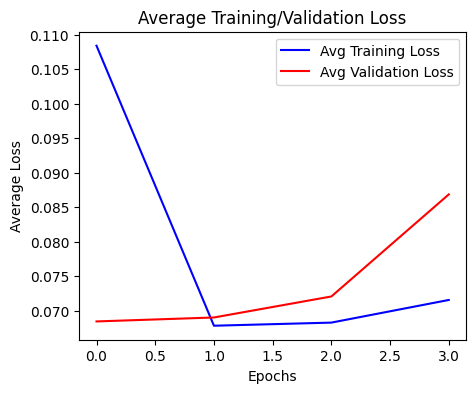

In [9]:
# Fine-Tuning for Valence Regression
valence_data = SpectrogramDataset(
    multitask_path,
    class_mapping=CLASS_MAPPING,
    train=True,
    regression=1,  # Regression task for valence
)

valence_train_dl, valence_val_dl = torch_train_val_split(
    dataset=valence_data,
    batch_eval=BATCH_SIZE,
    batch_train=BATCH_SIZE,
    val_size=VAL_SIZE,
    shuffle=True,
)

# Initialize model for regression
pretrained_backbone = ASTBackbone(
    fstride=10,
    tstride=10,
    input_fdim=valence_data[0][0].shape[1],
    input_tdim=valence_data[0][0].shape[0],
    imagenet_pretrain=False,
    model_size=model_size,
    feature_size=1,  # Single output for regression
)
pretrained_backbone.load_state_dict(torch.load(pretrained_weights, weights_only=True), strict=False)
# Freeze all but the last 2 Transformer layers
pretrained_backbone.freeze_layers(unfrozen_layers=2)

valence_model = Regressor(pretrained_backbone).to(DEVICE)

# Define optimizer after freezing layers to avoid updating frozen parameters
valence_optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, valence_model.parameters()),  # Only trainable params
    lr=LR
)

finetuned_valence_weights = model_weights_path + model_size + "_ast_valence_finetuning.pth"

if LOAD_PRETRAINED:
    valence_model.load_state_dict(torch.load(finetuned_valence_weights, map_location=DEVICE, weights_only=True))
else:
    # Fine-tune the model for Valence
    train_losses, val_losses = train(
        valence_model,
        valence_train_dl,
        valence_val_dl,
        valence_optimizer,
        EPOCHS,
        device=DEVICE,
        regression_flag=True,
        patience=3,
        save_path=finetuned_valence_weights,
    )
    plot_train_val_losses(train_losses, val_losses, save_title=f"assets/valence_finetuned_ast_train_val_losses.png")

In [10]:
y_true, y_pred, spear_corrs, pear_corrs = test_model(valence_model, energy_val_dl, DEVICE, regression_flag=True)

print("Fine-Tuned AST Regressor on Valence Dataset")
get_regression_report(y_pred, y_true, spear_corrs, pear_corrs)

Fine-Tuned AST Regressor on Valence Dataset
	AverageSpearman Correlation: -0.1054
	Average Pearson Correlation: -0.1247
	MSE: 0.0635
	MAE: 0.2030
	RMSE: 0.2519
	Mean Absolute Percentage Error (MAPE): 74.8112%
	R^2 Score: -0.0262
	Explained Variance Score: 0.0005


#### Use the pretrained weights from the model trained on *fma_genre_spectrograms* and fine-tune a Regressor on the *danceability* Dataset 


Free GPU Memory: 95.96%
Training started for model checkpoint...
Epoch 1/100
	Average Training Loss: 0.06918507736110319 (46.64s)
	Average Validation Loss: 0.030522974773443172(4.47s)
Epoch 2/100
	Average Training Loss: 0.031831146349751316 (46.30s)
	Average Validation Loss: 0.03073699802293309(4.50s)
Epoch 3/100
	Average Training Loss: 0.03100707669602295 (45.96s)
	Average Validation Loss: 0.029775974673352072(4.49s)
Epoch 4/100
	Average Training Loss: 0.030621256329020304 (45.43s)
	Average Validation Loss: 0.02780901308038405(4.46s)
Epoch 5/100
	Average Training Loss: 0.027076131079049236 (45.45s)
	Average Validation Loss: 0.023876086476125886(5.06s)
Epoch 6/100
	Average Training Loss: 0.0220859102014683 (46.54s)
	Average Validation Loss: 0.024404852717582668(4.48s)
Epoch 7/100
	Average Training Loss: 0.02189585938637631 (45.77s)
	Average Validation Loss: 0.021046083586822664(4.51s)
Epoch 8/100
	Average Training Loss: 0.01905824447388604 (46.96s)
	Average Validation Loss: 0.020945443

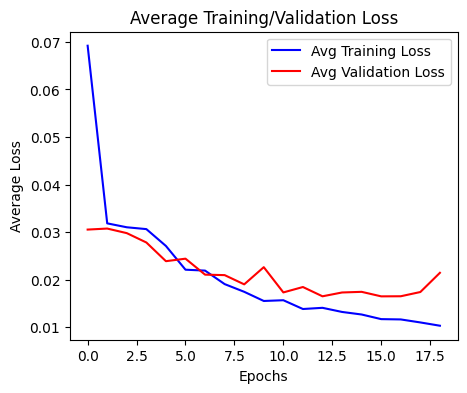

In [11]:
print(f"Free GPU Memory: {free_gpu_memory():.2f}%")

# Fine-Tuning for Danceability Regression
danceability_data = SpectrogramDataset(
    multitask_path,
    class_mapping=CLASS_MAPPING,
    train=True,
    regression=3,  # Regression task for danceability
)

danceability_train_dl, danceability_val_dl = torch_train_val_split(
    dataset=danceability_data, 
    batch_eval=BATCH_SIZE, 
    batch_train=BATCH_SIZE, 
    val_size=VAL_SIZE, 
    shuffle=True
)

# Initialize model for regression
pretrained_backbone = ASTBackbone(
    fstride=10,
    tstride=10,
    input_fdim=danceability_data[0][0].shape[1],
    input_tdim=danceability_data[0][0].shape[0],
    imagenet_pretrain=False,
    model_size=model_size,
    feature_size=1,  # Single output for regression
)
pretrained_backbone.load_state_dict(torch.load(pretrained_weights, weights_only=True), strict=False)
# Freeze all but the last 2 Transformer layers
pretrained_backbone.freeze_layers(unfrozen_layers=2)

danceability_model = Regressor(pretrained_backbone).to(DEVICE)

# Define optimizer after freezing layers to avoid updating frozen parameters
danceability_optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, danceability_model.parameters()),  # Only trainable params
    lr=LR
)

finetuned_danceability_weights = model_weights_path + model_size + "_ast_danceability_finetuning.pth"

if LOAD_PRETRAINED:
    danceability_model.load_state_dict(torch.load(finetuned_danceability_weights, map_location=DEVICE, weights_only=True))
else:
    # Fine-tune the model for Valence
    train_losses, val_losses = train(
        danceability_model,
        danceability_train_dl,
        danceability_val_dl,
        danceability_optimizer,
        EPOCHS,
        device=DEVICE,
        regression_flag=True,
        patience=3,
        save_path=finetuned_danceability_weights,
    )
    plot_train_val_losses(train_losses, val_losses, save_title=f"assets/danceability_finetuned_ast_train_val_losses.png")

In [12]:
y_true, y_pred, spear_corrs, pear_corrs = test_model(danceability_model, danceability_val_dl, DEVICE, regression_flag=True)

print("Fine-Tuned AST Regressor on Danceability Dataset")
get_regression_report(y_pred, y_true, spear_corrs, pear_corrs)

Fine-Tuned AST Regressor on Danceability Dataset
	Average Spearman Correlation: 0.6556
	Average Pearson Correlation: 0.6679
	MSE: 0.0214
	MAE: 0.1100
	RMSE: 0.1464
	Mean Absolute Percentage Error (MAPE): 29.7846%
	R^2 Score: 0.2892
	Explained Variance Score: 0.4512
